# Calculate Polarization Fraction for DSHARP opacities

### Conventions & Definitions

The phase function is defined such that:
$$\Phi(\mu) = \Phi(\cos\theta) = \frac{4\pi}{\kappa_\mathrm{sca}} Z_{11}(\theta)$$

The phase function averaged over the solid angle should be normalized
$$\frac{1}{4\pi}\int\Phi(\mu)\mathrm{d}\mu \stackrel{!}{=} 1$$

Polarization fraction $P$ (90 degree) and Albedo $\omega$ are 

\begin{align}
P &= \left|\frac{Z_{12,\mathrm{eff}}}{Z_{11,\mathrm{eff}}}\right|_{90^\circ}\\
\omega &= \frac{\kappa_\mathrm{sca}}{\kappa_\mathrm{sca}+\kappa_\mathrm{abs}}
\end{align}

Convention used in RADMC3D and also Kataoka et al. 2015 mostly follows Bohren & Huffman 1983, see also RADMC-3D manual, shown here for reference

\begin{align}
\begin{pmatrix}
I_s\\
Q_s\\
U_s\\
V_s
\end{pmatrix}
&=
\frac{m}{a^2}
\begin{pmatrix}
Z_{11} & Z_{12} & 0 & 0 \\
Z_{12} & Z_{11} & 0 & 0 \\
0 & 0 & Z_{33} & Z_{34} \\
0 & 0 & -Z_{34} & Z_{33} \\
\end{pmatrix}
\begin{pmatrix}
I_i\\
Q_i\\
U_i\\
V_i
\end{pmatrix}\\
\kappa_\mathrm{sca} &= \oint Z_{11}(a,\theta)\,\mathrm{d}\Omega \\
Z_{11,\mathrm{eff}}(\theta) &= \frac{\int_{a_\mathrm{min}}^{a_\mathrm{max}}\, Z_{11}(a,\theta)\,n(a)\,\mathrm{da}}{  
\int_{a_\mathrm{min}}^{a_\mathrm{max}}\,n(a)\,\mathrm{da}} \\
g &= \frac{2\pi}{\kappa_\mathrm{sca}} \int_{-1}^1 \, Z_{11}(\mu)\,\mu\,\mathrm{d}\mu \\
S_{11} &= \frac{1}{2}\left(\left|S_{1}\right|^2 + \left|S_{2}\right|^2\right) \\
S_{12} &= \frac{1}{2}\left(\left|S_{2}\right|^2 - \left|S_{1}\right|^2\right) \\
S_{33} &= \frac{1}{2}\left(S_2^*\,S_1 + S_2\,S_1^*\right)\\
S_{34} &= i\,\frac{1}{2} \left(S_2^*\,S_1 - S_2\,S_1^*\right) \\
\Phi(\theta) &= \frac{1}{\sigma_\mathrm{sca}}\,S_{11}(\cos\theta) \\
\sigma &= \kappa\,m \\
Z_{ij,\mathrm{RADMC-3D}} &= \frac{S_{ij}}{k^2\,m} \\
k &= \frac{2\pi}{\lambda}\\
\Rightarrow Z_{ij} &= S_{ij} \frac{\lambda^2}{4\,\pi^2\,m}
\end{align}

### Calculation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dsharp_opac as do
%matplotlib inline

Get optical constants for the DSHARP mix

In [2]:
oc, rho_s = do.get_dsharp_mix()

Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |


Define size, mass, and wavelength grid and calculate the opacities. Here we picked a large number of angles. To just calculate $P_{90}$, this is not necessary, but when calculating the scattering matrix, we are doing a sanity check, if the integral over the angles reproduces the scattering opacity. With too few angles, this test would fail.

In [3]:
a   = np.logspace(-4, -1, 100)
m   = 4 * np.pi / 3 * rho_s * a**3
lam = np.array([0.087, 0.1, 0.13]) # np.logspace(-4, 0, 60)

res = do.get_opacities(a, lam, rho_s, oc, extrapolate_large_grains=False, n_angle=100)

k_abs = res['k_abs']
k_sca = res['k_sca']
S1    = res['S1']
S2    = res['S2']
theta = res['theta']

# index where theta = 90 degree

i90 = theta.searchsorted(90)

Mie ... Done!


Calculate the scattering matrix elements. We also pass the angles and the scattering opacity to perform the normalization test.

In [4]:
zscat = do.calculate_mueller_matrix(lam, m, S1, S2, theta=theta, k_sca=k_sca)['zscat']

Size average the first two Müller matrix elements and calculate the polarization fraction at ${90}^\circ$

In [5]:
Z11eff = np.zeros([len(a), len(lam)])
Z12eff = np.zeros_like(Z11eff)
omega = np.zeros_like(Z11eff)

# make a loop over the maximum particle size
for ia, _a in enumerate(a):
    
    # make a normalized MRN distribution
    
    distri = a**0.5
    distri[a > _a] = 0
    distri /= distri.sum()
    
    # average the scattering matrix elements

    Z11eff[ia] = np.sum(zscat[:, :, i90, 0] * distri[:, None], 0)
    Z12eff[ia] = np.sum(zscat[:, :, i90, 1] * distri[:, None], 0)
    
    # average the opacities to get the average albedo
    
    k_a = np.sum(k_abs * distri[:, None], 0)
    k_s = np.sum(k_sca * distri[:, None], 0)
    omega[ia] = k_s / (k_a + k_s)
    
# calculate polarization fraction at 90 degree

P = np.abs(Z12eff / Z11eff)

Plot the contributions like in Kataoka et al.

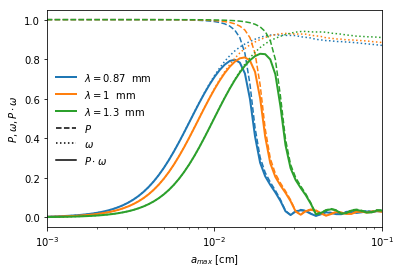

In [6]:
fig, ax = plt.subplots()

for i,_lam in enumerate(lam):
    line, = ax.semilogx(a, P[:, i],'--')
    ax.semilogx(a, omega[:, i], ls=':', c=line.get_color())
    ax.semilogx(a, P[:, i] * omega[:, i], ls='-', lw=2, c=line.get_color(), label=f'$\lambda = {_lam * 10:2.2g}$  mm')
    
ax.set_xlim(1e-3, 1e-1)
ax.set_xlabel('$a_{max}$ [cm]')
ax.set_ylabel('$P, \omega, P\cdot\omega$')
ax.plot([],[],'k--', label='$P$')
ax.plot([],[],'k:', label='$\omega$')
ax.plot([],[],'k-', label='$P\cdot \omega$')
ax.legend().get_frame().set_alpha(0)
fig.savefig('DSHARP_polarization.pdf', transparent=True)

#### Test: write out the scattering matrix of one species for RADMC3D

In [8]:
# add the scattering matrix to the dictionary
res['zscat'] = zscat

# select a scpecies to write out

i_grain = a.searchsorted(0.1)

do.write_radmc3d_scatmat_file(i_grain, res, f'species_{i_grain}')